In [1]:
#%load_ext autoreload
#%autoreload 2


import sys
sys.path.append("../../mrf-sim/")
sys.path.append("../../epgpy/")
sys.path.append("../../machines/")
sys.path.append("../../mutools/")
sys.path.append("../../dicomstack/")


#import matplotlib
#matplotlib.u<se("TkAgg")
from mrfsim import T1MRF
from image_series import *
from dictoptimizers import SimpleDictSearch
from utils_mrf import *

import json
import readTwix as rT
import time
import os
from numpy.lib.format import open_memmap
from numpy import memmap
import pickle
from scipy.io import loadmat,savemat
import twixtools
from mutools import io
import cv2
import scipy
%matplotlib inline


import scipy
import scipy.cluster.hierarchy as sch


def calc_grad_entropy(v,w=None):
    ndim = v.ndim
    grad_norm = 0
    if w is None:
        w=v.ndim*[1]
    for axis in range(ndim):
        pad = v.ndim * [(0, 0)]
        pad[axis] = (0, 1)
        pad = tuple(pad)
        grad = np.diff(np.pad(v, pad, mode="constant"), axis=axis)

        grad_norm += (w[axis]*np.abs(grad)) ** 2

    grad_norm = np.sqrt(grad_norm)
    p = grad_norm / np.sum(grad_norm)
    p[p==0]=1 #pixel with value 0 are crashing the algo
    return np.sum(-np.log2(p) * p)

def calc_entropy(v):
    ndim = v.ndim
    #grad_norm = 0
    p = np.abs(v)
    p/=np.max(p)
    #p[p==0]=1 #pixel with value 0 are crashing the algo
    return np.sum(-np.log2(p) * p)





Could not import SPIJN


In [2]:

base_folder = "../data/InVivo/3D"

localfile = "/patient.004.v1/meas_MID00022_FID03367_raFin_3D_tra_1x1x5mm_FULL_1.dat"


use_GPU = False
light_memory_usage=True


filename = base_folder+localfile

#filename="./data/InVivo/3D/20211221_EV_MRF/meas_MID00043_FID42065_raFin_3D_tra_1x1x5mm_us2_vivo.dat"
#filename="./data/InVivo/3D/20211119_EV_MRF/meas_MID00043_FID42065_raFin_3D_tra_1x1x5mm_us2_vivo.dat"
#filename="./data/InVivo/3D/20211119_EV_MRF/meas_MID00043_FID42065_raFin_3D_tra_1x1x5mm_us2_vivo.dat"

filename_save=str.split(filename,".dat") [0]+".npy"
filename_nav_save=str.split(filename,".dat") [0]+"_nav.npy"

folder = "/".join(str.split(filename,"/")[:-1])


filename_b1 = str.split(filename,".dat") [0]+"_b1.npy"
filename_seqParams = str.split(filename,".dat") [0]+"_seqParams.pkl"

filename_volume = str.split(filename,".dat") [0]+"_volumes.npy"
filename_kdata = str.split(filename,".dat") [0]+"_kdata.npy"
filename_kdata_modif = str.split(filename,".dat") [0]+"_kdata_modif.npy"
filename_mask= str.split(filename,".dat") [0]+"_mask.npy"

file = open(filename_seqParams, "rb")
dico_seqParams = pickle.load(file)
file.close()

use_navigator_dll=dico_seqParams["use_navigator_dll"]

if use_navigator_dll:
    meas_sampling_mode=dico_seqParams["alFree"][14]
    nb_gating_spokes = dico_seqParams["alFree"][6]
else:
    meas_sampling_mode = dico_seqParams["alFree"][12]
    nb_gating_spokes = 0

if nb_gating_spokes>0:
    meas_orientation =  dico_seqParams["alFree"][11]
    if meas_orientation==1:
        nav_direction = "READ"
    elif meas_orientation==2:
        nav_direction = "PHASE"
    elif meas_orientation==3:
        nav_direction = "SLICE"

nb_segments = dico_seqParams["alFree"][4]

x_FOV = dico_seqParams["x_FOV"]
y_FOV = dico_seqParams["y_FOV"]
z_FOV = dico_seqParams["z_FOV"]
nb_part = dico_seqParams["nb_part"]



del dico_seqParams

if meas_sampling_mode==1:
    incoherent=False
    mode = None
elif meas_sampling_mode==2:
    incoherent = True
    mode = "old"
elif meas_sampling_mode==3:
    incoherent = True
    mode = "new"

    
nb_allspokes=nb_segments
undersampling_factor=1

data_for_nav=np.load(filename_nav_save)

npoint_nav = data_for_nav.shape[-1]
nb_slices=data_for_nav.shape[1]
nb_channels=data_for_nav.shape[0]

all_timesteps = np.arange(nb_allspokes)
nav_timesteps=all_timesteps[::int(nb_allspokes/nb_gating_spokes)]

nav_traj=Navigator3D(direction=[0,0,1],npoint=npoint_nav,nb_slices=nb_slices,applied_timesteps=list(nav_timesteps))
#test_traj = nav_traj.get_traj()

nav_image_size = (int(npoint_nav/2),)

# Best channel selection based on PCA

In [3]:
image_nav_all_channels=[]
for j in range(nb_channels):
    images_series_rebuilt_nav_ch = simulate_nav_images_multi(np.expand_dims(data_for_nav[j],axis=0), nav_traj, nav_image_size, b1=None)
    image_nav_ch = np.abs(images_series_rebuilt_nav_ch)
    # plt.figure()
    #plt.imshow(image_nav_ch.reshape(-1, int(npoint / 2)).T, cmap="gray")
    #plt.title("Image channel {}".format(j))
    image_nav_all_channels.append(image_nav_ch)
#plt.close("all")
image_nav_all_channels=np.array(image_nav_all_channels)

complex64
float64


100%|██████████| 1/1 [00:07<00:00,  7.38s/it]


complex64
float64


100%|██████████| 1/1 [00:07<00:00,  7.03s/it]


complex64
float64


100%|██████████| 1/1 [00:07<00:00,  7.20s/it]


complex64
float64


100%|██████████| 1/1 [00:07<00:00,  7.02s/it]


complex64
float64


100%|██████████| 1/1 [00:07<00:00,  7.47s/it]


complex64
float64


100%|██████████| 1/1 [00:07<00:00,  7.27s/it]


complex64
float64


100%|██████████| 1/1 [00:06<00:00,  6.78s/it]


complex64
float64


100%|██████████| 1/1 [00:06<00:00,  6.86s/it]


complex64
float64


100%|██████████| 1/1 [00:06<00:00,  6.89s/it]


complex64
float64


100%|██████████| 1/1 [00:06<00:00,  6.84s/it]


complex64
float64


100%|██████████| 1/1 [00:07<00:00,  7.08s/it]


complex64
float64


100%|██████████| 1/1 [00:06<00:00,  6.83s/it]


complex64
float64


100%|██████████| 1/1 [00:07<00:00,  7.38s/it]


complex64
float64


100%|██████████| 1/1 [00:07<00:00,  7.14s/it]


complex64
float64


100%|██████████| 1/1 [00:07<00:00,  7.16s/it]


complex64
float64


100%|██████████| 1/1 [00:07<00:00,  7.06s/it]


complex64
float64


100%|██████████| 1/1 [00:07<00:00,  7.26s/it]


complex64
float64


100%|██████████| 1/1 [00:06<00:00,  6.98s/it]


complex64
float64


100%|██████████| 1/1 [00:06<00:00,  6.94s/it]


complex64
float64


100%|██████████| 1/1 [00:07<00:00,  7.14s/it]


complex64
float64


100%|██████████| 1/1 [00:07<00:00,  7.13s/it]


complex64
float64


100%|██████████| 1/1 [00:06<00:00,  6.97s/it]


complex64
float64


100%|██████████| 1/1 [00:07<00:00,  7.41s/it]


complex64
float64


100%|██████████| 1/1 [00:06<00:00,  6.95s/it]


complex64
float64


100%|██████████| 1/1 [00:07<00:00,  7.21s/it]


complex64
float64


100%|██████████| 1/1 [00:06<00:00,  6.71s/it]


complex64
float64


100%|██████████| 1/1 [00:07<00:00,  7.22s/it]


complex64
float64


100%|██████████| 1/1 [00:07<00:00,  7.29s/it]


complex64
float64


100%|██████████| 1/1 [00:07<00:00,  7.05s/it]


complex64
float64


100%|██████████| 1/1 [00:07<00:00,  7.17s/it]


complex64
float64


100%|██████████| 1/1 [00:07<00:00,  7.15s/it]


complex64
float64


100%|██████████| 1/1 [00:06<00:00,  6.80s/it]


complex64
float64


100%|██████████| 1/1 [00:07<00:00,  7.43s/it]


complex64
float64


100%|██████████| 1/1 [00:07<00:00,  7.20s/it]


In [36]:
image_nav_all_channels.shape

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(34, 48, 50, 100)

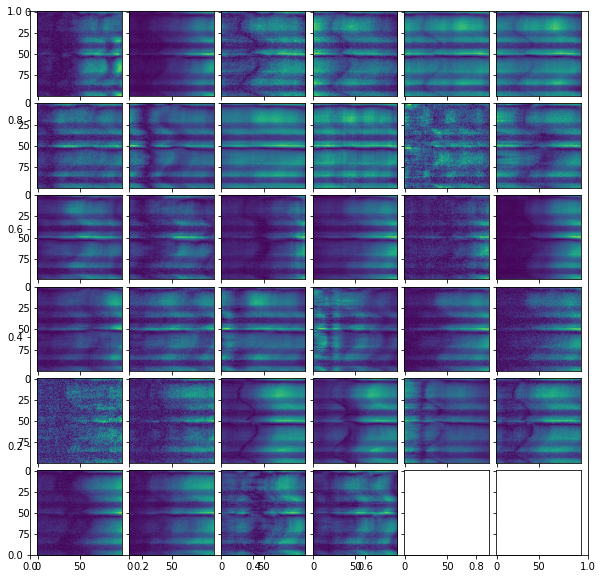

In [46]:
nb_cycles=2
plot_image_grid(image_nav_all_channels[:,:nb_cycles,:,:].reshape(nb_channels,-1,int(npoint_nav/2)),nb_row_col=(6,6))

In [61]:
shifts = list(range(-20, 20))
bottom = -shifts[0]
top = nav_image_size[0]-shifts[-1]

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [62]:
displacements_all_ch = []

for j in range(nb_channels):
    displacements = calculate_displacement(image_nav_all_channels[j], bottom, top, shifts, lambda_tv=0.001)
    displacements_all_ch.append(displacements)
    

100%|██████████| 2400/2400 [00:06<00:00, 358.25it/s]


In [63]:
displacements_all_ch=np.array(displacements_all_ch)

In [64]:
pca=PCAComplex(n_components_=1)
disp_transf = pca.fit_transform(displacements_all_ch)
np.argsort(disp_transf[:,0])

array([23, 30, 11, 16, 15,  3, 22, 14,  2, 12,  8,  4, 19,  5, 29,  9, 26,
       25, 21, 32, 18, 33, 27, 24, 17,  7, 10, 13, 20,  6,  1, 31, 28,  0])

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


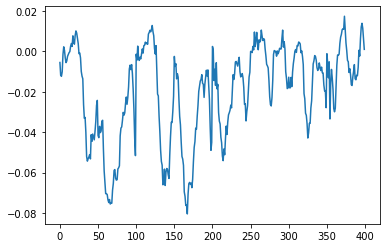

In [83]:
plt.plot(pca.components_[:400])

In [8]:
#channel 21 - liver
#channel 4 - back and liver

In [96]:
best_ch=np.argsort(disp_transf[:,0])[-1]
best_ch=2

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [97]:
best_ch

2

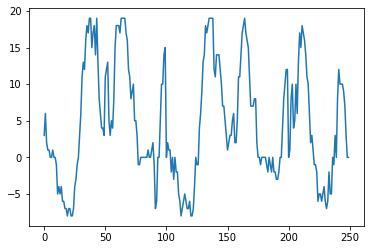

In [98]:
%matplotlib inline
plt.plot(displacements_all_ch[best_ch,:(nb_gating_spokes*5)])

In [104]:
shifts = list(range(-20, 20))
displacement_test = calculate_displacement(image_nav_all_channels[best_ch], 20, 80, shifts, lambda_tv=0.001)

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 2400/2400 [00:06<00:00, 353.12it/s]


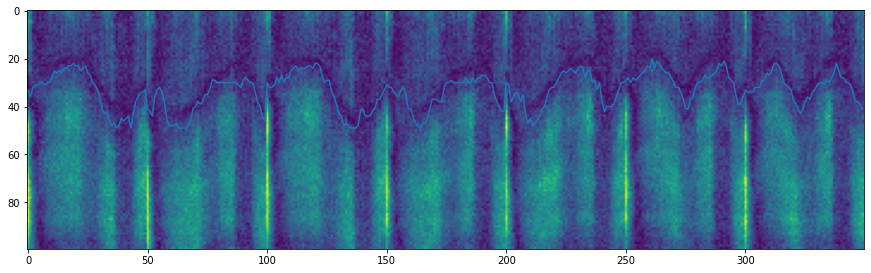

In [105]:
%matplotlib inline
nb_cycles=7
plt.figure(figsize=(15,10))
plt.imshow(image_nav_all_channels[best_ch,:nb_cycles,:,:].reshape(-1,int(npoint_nav/2)).T)
#plt.plot(80+displacements_all_ch[best_ch,:(nb_gating_spokes*nb_cycles)])
plt.plot(30+displacement_test[:(nb_gating_spokes*nb_cycles)])
#plt.plot(30-pca.components_[:nb_cycles*nb_gating_spokes]*250)

In [55]:

with open("../mrf_sequence.json") as f:
    sequence_config = json.load(f)


/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [122]:
TRs  =sequence_config["TR"]

In [123]:
TRs_gating=np.cumsum(np.array(TRs))[::int(nb_allspokes/nb_gating_spokes)]

In [124]:
TRs_gating

array([3.52000e+00, 1.02080e+02, 2.00640e+02, 2.99200e+02, 3.97760e+02,
       4.96320e+02, 5.94880e+02, 6.93440e+02, 7.92000e+02, 8.90560e+02,
       9.89120e+02, 1.08768e+03, 1.18624e+03, 1.28480e+03, 1.38336e+03,
       1.48192e+03, 1.58048e+03, 1.67904e+03, 1.77760e+03, 1.87616e+03,
       1.97472e+03, 2.07328e+03, 2.17184e+03, 2.27040e+03, 2.36896e+03,
       2.46752e+03, 2.56608e+03, 2.66464e+03, 2.76320e+03, 2.87554e+03,
       3.00378e+03, 3.13202e+03, 3.26026e+03, 3.38850e+03, 3.51674e+03,
       3.64498e+03, 3.77322e+03, 3.90146e+03, 4.02970e+03, 4.15794e+03,
       4.28618e+03, 4.41442e+03, 4.54266e+03, 4.67680e+03, 4.83808e+03,
       4.99936e+03, 5.16064e+03, 5.32192e+03, 5.48320e+03, 5.64448e+03])

In [33]:
from scipy.interpolate import interp1d

/Users/constantinslioussarenko/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [74]:
from scipy.signal import butter,sosfilt

In [157]:
ch=best_ch
disp = displacement_test.reshape(nb_slices,-1)
disp_new=np.zeros(disp.shape,dtype=disp.dtype)

for sl in range(nb_slices):
    f = interp1d(TRs_gating,disp[sl],fill_value="extrapolate")
    filtered = sosfilt(sos, f(np.arange(0,TRs_gating[-1],Ts)))
    reinterp = interp1d(np.arange(0,TRs_gating[-1],Ts),filtered,fill_value="extrapolate")
    disp_new[sl]=reinterp(TRs_gating)
    
disp_new=disp_new.flatten()
    
    

/Users/constantinslioussarenko/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [158]:
disp_new.shape

(1800,)

/Users/constantinslioussarenko/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


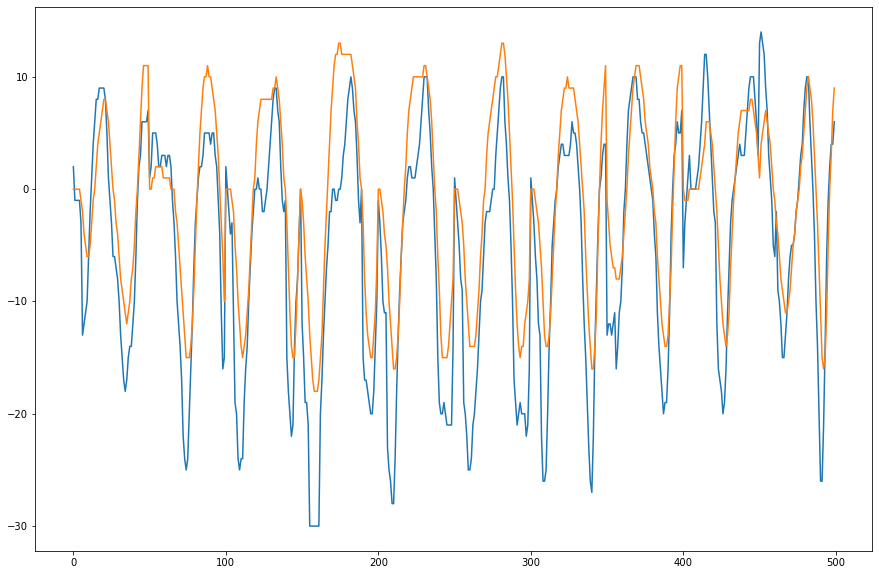

In [160]:
nb_cycles=10
plt.figure(figsize=(15,10))
plt.plot(displacement_test[:nb_cycles*nb_gating_spokes])
plt.plot(disp_new[:nb_cycles*nb_gating_spokes])

# Building full volumes - autofocus on best channel

In [161]:

#kdata_all_channels_all_slices = open_memmap(filename_kdata)
kdata_all_channels_all_slices = np.load(filename_kdata)

/Users/constantinslioussarenko/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


FileNotFoundError: [Errno 2] No such file or directory: '../data/InVivo/3D/patient.003.v1/meas_MID00130_FID02116_raFin_3D_tra_0_68x0_68x3mm_FULL_NoInv_kdata.npy'

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


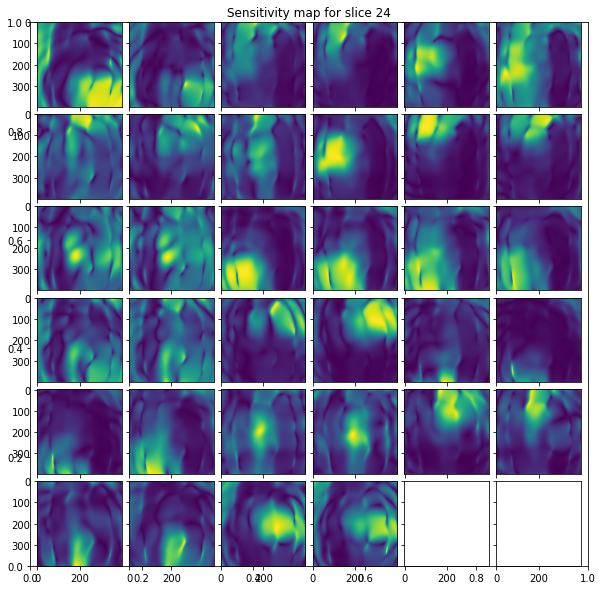

In [29]:
b1_all_slices=np.load(filename_b1)

%matplotlib inline
sl=int(b1_all_slices.shape[1]/2)
#sl=4
list_images = list(np.abs(b1_all_slices[:,sl,:,:]))
plot_image_grid(list_images,(6,6),title="Sensitivity map for slice {}".format(sl))


In [244]:
ch = best_ch

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:

dens_adj=False
npoint=kdata_all_channels_all_slices.shape[-1]
image_size=(nb_slices,int(npoint/2),int(npoint/2))
b1_full=np.ones((1,)+image_size)

In [311]:
selected_spokes=np.r_[800:1200]

In [312]:
len(selected_spokes)

400

In [314]:
del radial_traj

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [378]:
radial_traj=Radial3D(total_nspokes=nb_allspokes,undersampling_factor=undersampling_factor,npoint=npoint,nb_slices=nb_slices,incoherent=incoherent,mode=mode)
traj_all=radial_traj.get_traj()
radial_traj.traj = traj_all[selected_spokes]
radial_traj.total_nspokes=len(selected_spokes)


In [319]:
volume_ch=simulate_radial_undersampled_images_multi(np.expand_dims(kdata_all_channels_all_slices[ch][selected_spokes],axis=0), radial_traj, image_size, b1=b1_full,
                                                              density_adj=dens_adj, ntimesteps=1, useGPU=False,
                                                              normalize_kdata=False, memmap_file=None,
                                                              light_memory_usage=light_memory_usage,
                                                              normalize_volumes=True)[0]

(15360000, 3)
float32


100%|██████████| 1/1 [00:00<00:00, 45.61it/s]


Performing NUFFT


0it [00:00, ?it/s]
  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)



100%|██████████| 1/1 [00:01<00:00,  1.53s/it]
1it [00:01,  1.53s/it]


Normalizing by Coil Sensi


100%|██████████| 1/1 [00:00<00:00, 22.14it/s]


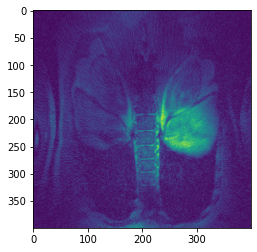

In [455]:
%matplotlib inline
plt.imshow(np.abs(volume_ch[14]))

#17 +/- 3 liver
# 7 +/- 1 back

<IPython.core.display.Javascript object>


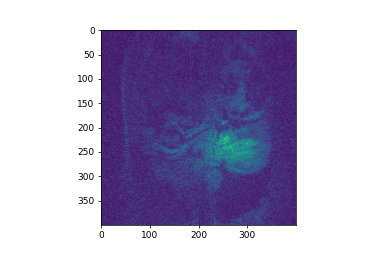

In [354]:
%matplotlib notebook
animate_images(volume_ch)


In [18]:
spoke_groups = np.argmin(np.abs(
        np.arange(0, nb_segments * nb_slices, 1).reshape(-1, 1) - np.arange(0, nb_segments * nb_slices,
                                                                          nb_segments / nb_gating_spokes).reshape(1,
                                                                                                                  -1)),
        axis=-1)

if not (nb_segments == nb_gating_spokes):
    spoke_groups = spoke_groups.reshape(nb_slices, nb_segments)
    spoke_groups[:-1, -int(nb_segments / nb_gating_spokes / 2) + 1:] = spoke_groups[:-1, -int(
            nb_segments / nb_gating_spokes / 2) + 1:] - 1
    spoke_groups = spoke_groups.flatten()

displacements_extrapolated = np.array([displacements_all_ch[ch][j] for j in spoke_groups])


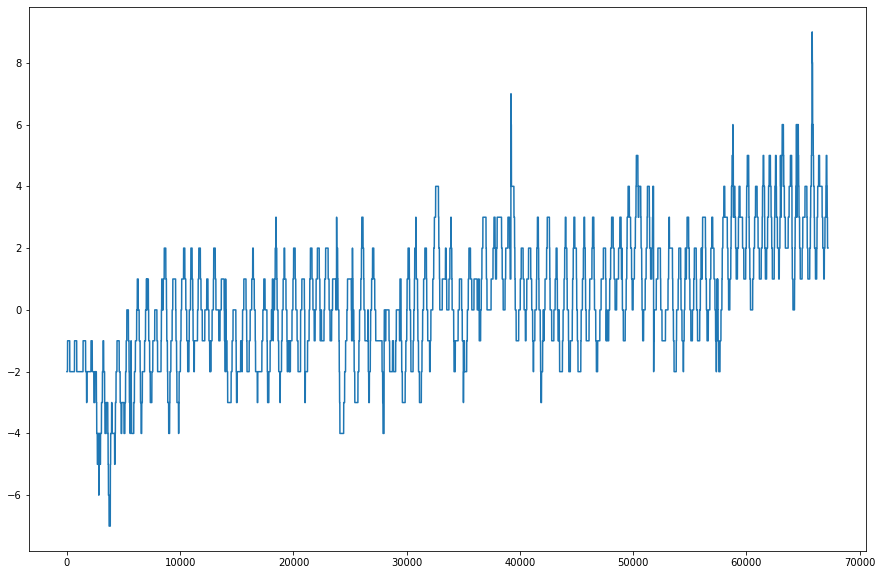

In [19]:
%matplotlib inline
plt.figure(figsize=(15,10))
plt.plot(displacements_extrapolated)

In [91]:
x = np.arange(1.0, 4.01, 0.5)
x = np.arange(-0.6, 1.01, 0.2)

y = np.array([0])
z = np.arange(-1.5, 1.51, 0.5)
z=np.array([0.0])
dz_ent=5

In [92]:
#print("Calculating Entropy for all movement ranges...")
#entropy_all = []
#ent_min = np.inf
#for dx in tqdm(x):
#    entropy_xzy = []
#    for dz in z:
#        entropy_zy=[]
#        for dy in y:
#            alpha = np.array([dx, dy, dz])
#            dr = np.expand_dims(alpha, axis=(0, 1)) * np.expand_dims(
#                displacements_extrapolated.reshape(nb_slices, nb_segments).T, axis=(2))
#            modif = np.exp(
#                1j * np.sum((radial_traj.get_traj().reshape(nb_segments, -1, npoint, 3) * np.expand_dims(dr, axis=2)),
#                            axis=-1))
#            data_modif = kdata_all_channels_all_slices[ch] * modif
#            volume_ch_modif = \
#                simulate_radial_undersampled_images_multi(np.expand_dims(data_modif,axis=0), radial_traj, image_size, b1=b1_full,
#                                                              density_adj=dens_adj, ntimesteps=1, useGPU=False,
#                                                              normalize_kdata=False, memmap_file=None,
#                                                              light_memory_usage=light_memory_usage,
#                                                              normalize_volumes=True)[0]
#
#
#            ent = calc_grad_entropy(volume_ch_modif[int(nb_slices/2)-dz_ent:int(nb_slices/2)+dz_ent])
#            entropy_zy.append(ent)
#            if ent < ent_min:
#                modif_final = modif
#                alpha_min = alpha
#                ent_min = ent
#        entropy_xzy.append(entropy_zy)
#    entropy_all.append(entropy_xzy)

Calculating Entropy for all movement ranges...


  0%|          | 0/9 [00:00<?, ?it/s]

(53760000, 3)



100%|██████████| 1/1 [00:00<00:00, 10.76it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(51916800, 3)
(51916800,)




100%|██████████| 1/1 [00:06<00:00,  6.28s/it]

1it [00:06,  6.28s/it]


Normalizing by Coil Sensi



 11%|█         | 1/9 [00:09<01:19,  9.88s/it]

(53760000, 3)



100%|██████████| 1/1 [00:00<00:00, 10.74it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(51916800, 3)
(51916800,)




100%|██████████| 1/1 [00:06<00:00,  6.35s/it]

1it [00:06,  6.36s/it]


Normalizing by Coil Sensi



 22%|██▏       | 2/9 [00:19<01:09,  9.90s/it]

(53760000, 3)



100%|██████████| 1/1 [00:00<00:00, 10.85it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(51916800, 3)
(51916800,)




100%|██████████| 1/1 [00:06<00:00,  6.47s/it]

1it [00:06,  6.48s/it]


Normalizing by Coil Sensi



 33%|███▎      | 3/9 [00:29<00:59,  9.95s/it]

(53760000, 3)



100%|██████████| 1/1 [00:00<00:00, 10.66it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(51916800, 3)
(51916800,)




100%|██████████| 1/1 [00:06<00:00,  6.35s/it]

1it [00:06,  6.36s/it]


Normalizing by Coil Sensi



 44%|████▍     | 4/9 [00:39<00:49,  9.93s/it]

(53760000, 3)



100%|██████████| 1/1 [00:00<00:00, 10.84it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(51916800, 3)
(51916800,)




100%|██████████| 1/1 [00:06<00:00,  6.31s/it]

1it [00:06,  6.32s/it]


Normalizing by Coil Sensi



 56%|█████▌    | 5/9 [00:49<00:39,  9.90s/it]

(53760000, 3)



100%|██████████| 1/1 [00:00<00:00, 10.80it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(51916800, 3)
(51916800,)




100%|██████████| 1/1 [00:06<00:00,  6.41s/it]

1it [00:06,  6.42s/it]


Normalizing by Coil Sensi



 67%|██████▋   | 6/9 [00:59<00:29,  9.93s/it]

(53760000, 3)



100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(51916800, 3)
(51916800,)




100%|██████████| 1/1 [00:06<00:00,  6.40s/it]

1it [00:06,  6.40s/it]


Normalizing by Coil Sensi



 78%|███████▊  | 7/9 [01:09<00:19,  9.95s/it]

(53760000, 3)



100%|██████████| 1/1 [00:00<00:00, 10.57it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(51916800, 3)
(51916800,)




100%|██████████| 1/1 [00:06<00:00,  6.50s/it]

1it [00:06,  6.50s/it]


Normalizing by Coil Sensi



 89%|████████▉ | 8/9 [01:19<00:10, 10.01s/it]

(53760000, 3)



100%|██████████| 1/1 [00:00<00:00, 10.79it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(51916800, 3)
(51916800,)




100%|██████████| 1/1 [00:06<00:00,  6.67s/it]

1it [00:06,  6.68s/it]


Normalizing by Coil Sensi



100%|██████████| 9/9 [01:29<00:00, 10.00s/it]


In [468]:
x = np.arange(1.0, 4.01, 0.5)
x = np.arange(-0.4, 1.01, 0.2)

y = np.array([0])
z = np.arange(-1.0, 0.01, 0.2)
#z=np.array([0.0])

#back
#center_pixel=(7,246,284)
#window=(2,100,100)

#liver
center_pixel=(17,246,284)
window=(6,100,100)

grad_weights = [0.1,1,1]

In [457]:
hann_3D = np.expand_dims((np.hanning(window[0]+2)[1:-1].reshape(-1,1)@np.hanning(window[1]+2)[1:-1].reshape(1,-1)),axis=-1)@np.hanning(window[2]+2)[1:-1].reshape(1,-1)
hann_3D=1


In [458]:
print("Calculating Entropy for all movement ranges...")
entropy_all = []
ent_min = np.inf
for dx in tqdm(x):
    entropy_xzy = []
    for dz in z:
        entropy_zy=[]
        for dy in y:
            alpha = np.array([dx, dy, dz])
            dr = np.expand_dims(alpha, axis=(0, 1)) * np.expand_dims(
                displacements_extrapolated.reshape(nb_slices, nb_segments).T, axis=(2))
            modif = np.exp(
                1j * np.sum((traj_all.reshape(nb_segments, -1, npoint, 3) * np.expand_dims(dr, axis=2)),
                            axis=-1))
            data_modif = kdata_all_channels_all_slices[ch] * modif
            volume_ch_modif = \
                simulate_radial_undersampled_images_multi(np.expand_dims(data_modif[selected_spokes],axis=0), radial_traj, image_size, b1=b1_full,
                                                              density_adj=dens_adj, ntimesteps=1, useGPU=False,
                                                              normalize_kdata=False, memmap_file=None,
                                                              light_memory_usage=light_memory_usage,
                                                              normalize_volumes=True)[0]


            ent = calc_grad_entropy(volume_ch_modif[center_pixel[0]-int(window[0]/2):center_pixel[0]+int(window[0]/2),center_pixel[1]-int(window[1]/2):center_pixel[1]+int(window[1]/2),center_pixel[2]-int(window[2]/2):center_pixel[2]+int(window[2]/2)]*hann_3D,w=grad_weights)
            entropy_zy.append(ent)
            if ent < ent_min:
                modif_final = modif
                alpha_min = alpha
                ent_min = ent
        entropy_xzy.append(entropy_zy)
    entropy_all.append(entropy_xzy)

Calculating Entropy for all movement ranges...


  0%|          | 0/8 [00:00<?, ?it/s]

(15360000, 3)



100%|██████████| 1/1 [00:00<00:00, 38.77it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)




100%|██████████| 1/1 [00:02<00:00,  2.42s/it]

1it [00:02,  2.43s/it]


Normalizing by Coil Sensi



100%|██████████| 1/1 [00:00<00:00, 21.39it/s]


(15360000, 3)



100%|██████████| 1/1 [00:00<00:00, 34.09it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)




100%|██████████| 1/1 [00:02<00:00,  2.40s/it]

1it [00:02,  2.40s/it]


Normalizing by Coil Sensi



100%|██████████| 1/1 [00:00<00:00, 19.97it/s]


(15360000, 3)



100%|██████████| 1/1 [00:00<00:00, 38.86it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)




100%|██████████| 1/1 [00:02<00:00,  2.43s/it]

1it [00:02,  2.44s/it]


Normalizing by Coil Sensi



100%|██████████| 1/1 [00:00<00:00, 22.49it/s]


(15360000, 3)



100%|██████████| 1/1 [00:00<00:00, 38.57it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)




100%|██████████| 1/1 [00:02<00:00,  2.22s/it]

1it [00:02,  2.23s/it]


Normalizing by Coil Sensi



100%|██████████| 1/1 [00:00<00:00, 22.95it/s]


(15360000, 3)



100%|██████████| 1/1 [00:00<00:00, 36.79it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)




100%|██████████| 1/1 [00:02<00:00,  2.35s/it]

1it [00:02,  2.35s/it]


Normalizing by Coil Sensi



100%|██████████| 1/1 [00:00<00:00, 25.51it/s]


(15360000, 3)



100%|██████████| 1/1 [00:00<00:00, 37.96it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)




100%|██████████| 1/1 [00:02<00:00,  2.40s/it]

1it [00:02,  2.40s/it]


Normalizing by Coil Sensi



 12%|█▎        | 1/8 [00:36<04:18, 36.96s/it]

(15360000, 3)



100%|██████████| 1/1 [00:00<00:00, 38.63it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)




100%|██████████| 1/1 [00:02<00:00,  2.33s/it]

1it [00:02,  2.34s/it]


Normalizing by Coil Sensi



100%|██████████| 1/1 [00:00<00:00, 23.39it/s]


(15360000, 3)



100%|██████████| 1/1 [00:00<00:00, 38.80it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)




100%|██████████| 1/1 [00:02<00:00,  2.27s/it]

1it [00:02,  2.28s/it]


Normalizing by Coil Sensi



100%|██████████| 1/1 [00:00<00:00, 24.05it/s]


(15360000, 3)



100%|██████████| 1/1 [00:00<00:00, 38.92it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)




100%|██████████| 1/1 [00:02<00:00,  2.23s/it]

1it [00:02,  2.24s/it]


Normalizing by Coil Sensi



100%|██████████| 1/1 [00:00<00:00, 23.30it/s]


(15360000, 3)



100%|██████████| 1/1 [00:00<00:00, 38.97it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)




100%|██████████| 1/1 [00:02<00:00,  2.24s/it]

1it [00:02,  2.24s/it]


Normalizing by Coil Sensi



100%|██████████| 1/1 [00:00<00:00, 23.43it/s]


(15360000, 3)



100%|██████████| 1/1 [00:00<00:00, 37.96it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)




100%|██████████| 1/1 [00:02<00:00,  2.39s/it]

1it [00:02,  2.40s/it]


Normalizing by Coil Sensi



100%|██████████| 1/1 [00:00<00:00, 22.60it/s]


(15360000, 3)



100%|██████████| 1/1 [00:00<00:00, 38.43it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)




100%|██████████| 1/1 [00:02<00:00,  2.40s/it]

1it [00:02,  2.41s/it]


Normalizing by Coil Sensi



 25%|██▌       | 2/8 [01:13<03:39, 36.55s/it]

(15360000, 3)



100%|██████████| 1/1 [00:00<00:00, 38.63it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)




100%|██████████| 1/1 [00:02<00:00,  2.39s/it]

1it [00:02,  2.39s/it]


Normalizing by Coil Sensi



100%|██████████| 1/1 [00:00<00:00, 19.40it/s]


(15360000, 3)



100%|██████████| 1/1 [00:00<00:00, 38.18it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)




100%|██████████| 1/1 [00:02<00:00,  2.40s/it]

1it [00:02,  2.41s/it]


Normalizing by Coil Sensi



100%|██████████| 1/1 [00:00<00:00, 22.88it/s]


(15360000, 3)



100%|██████████| 1/1 [00:00<00:00, 38.08it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)




100%|██████████| 1/1 [00:02<00:00,  2.44s/it]

1it [00:02,  2.45s/it]


Normalizing by Coil Sensi



100%|██████████| 1/1 [00:00<00:00, 17.92it/s]


(15360000, 3)



100%|██████████| 1/1 [00:00<00:00, 36.85it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)




100%|██████████| 1/1 [00:02<00:00,  2.39s/it]

1it [00:02,  2.40s/it]


Normalizing by Coil Sensi



100%|██████████| 1/1 [00:00<00:00, 23.86it/s]


(15360000, 3)



100%|██████████| 1/1 [00:00<00:00, 38.66it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)




100%|██████████| 1/1 [00:02<00:00,  2.41s/it]

1it [00:02,  2.41s/it]


Normalizing by Coil Sensi



100%|██████████| 1/1 [00:00<00:00, 22.93it/s]


(15360000, 3)



100%|██████████| 1/1 [00:00<00:00, 38.24it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)




100%|██████████| 1/1 [00:02<00:00,  2.24s/it]

1it [00:02,  2.25s/it]


Normalizing by Coil Sensi



 38%|███▊      | 3/8 [01:49<03:02, 36.53s/it]

(15360000, 3)



100%|██████████| 1/1 [00:00<00:00, 38.95it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)




100%|██████████| 1/1 [00:02<00:00,  2.21s/it]

1it [00:02,  2.21s/it]


Normalizing by Coil Sensi



100%|██████████| 1/1 [00:00<00:00, 22.84it/s]


(15360000, 3)



100%|██████████| 1/1 [00:00<00:00, 39.15it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)




100%|██████████| 1/1 [00:02<00:00,  2.24s/it]

1it [00:02,  2.25s/it]


Normalizing by Coil Sensi



100%|██████████| 1/1 [00:00<00:00, 23.40it/s]


(15360000, 3)



100%|██████████| 1/1 [00:00<00:00, 39.05it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)




100%|██████████| 1/1 [00:02<00:00,  2.23s/it]

1it [00:02,  2.24s/it]


Normalizing by Coil Sensi



100%|██████████| 1/1 [00:00<00:00, 21.98it/s]


(15360000, 3)



100%|██████████| 1/1 [00:00<00:00, 39.30it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)




100%|██████████| 1/1 [00:02<00:00,  2.22s/it]

1it [00:02,  2.23s/it]


Normalizing by Coil Sensi



100%|██████████| 1/1 [00:00<00:00, 23.40it/s]


(15360000, 3)



100%|██████████| 1/1 [00:00<00:00, 38.82it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)




100%|██████████| 1/1 [00:02<00:00,  2.23s/it]

1it [00:02,  2.23s/it]


Normalizing by Coil Sensi



100%|██████████| 1/1 [00:00<00:00, 23.02it/s]


(15360000, 3)



100%|██████████| 1/1 [00:00<00:00, 37.62it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)




100%|██████████| 1/1 [00:02<00:00,  2.27s/it]

1it [00:02,  2.28s/it]


Normalizing by Coil Sensi



 50%|█████     | 4/8 [02:25<02:24, 36.16s/it]

(15360000, 3)



100%|██████████| 1/1 [00:00<00:00, 39.37it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)




100%|██████████| 1/1 [00:02<00:00,  2.20s/it]

1it [00:02,  2.21s/it]


Normalizing by Coil Sensi



100%|██████████| 1/1 [00:00<00:00, 23.50it/s]


(15360000, 3)



100%|██████████| 1/1 [00:00<00:00, 38.57it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)




100%|██████████| 1/1 [00:02<00:00,  2.21s/it]

1it [00:02,  2.22s/it]


Normalizing by Coil Sensi



100%|██████████| 1/1 [00:00<00:00, 23.04it/s]


(15360000, 3)



100%|██████████| 1/1 [00:00<00:00, 37.87it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)




100%|██████████| 1/1 [00:02<00:00,  2.28s/it]

1it [00:02,  2.28s/it]


Normalizing by Coil Sensi



100%|██████████| 1/1 [00:00<00:00, 23.04it/s]


(15360000, 3)



100%|██████████| 1/1 [00:00<00:00, 39.26it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)




100%|██████████| 1/1 [00:02<00:00,  2.24s/it]

1it [00:02,  2.25s/it]


Normalizing by Coil Sensi



100%|██████████| 1/1 [00:00<00:00, 23.30it/s]


(15360000, 3)



100%|██████████| 1/1 [00:00<00:00, 39.09it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)




100%|██████████| 1/1 [00:02<00:00,  2.23s/it]

1it [00:02,  2.23s/it]


Normalizing by Coil Sensi



100%|██████████| 1/1 [00:00<00:00, 22.58it/s]


(15360000, 3)



100%|██████████| 1/1 [00:00<00:00, 38.29it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)




100%|██████████| 1/1 [00:02<00:00,  2.19s/it]

1it [00:02,  2.20s/it]


Normalizing by Coil Sensi



 62%|██████▎   | 5/8 [03:00<01:47, 35.97s/it]

(15360000, 3)



100%|██████████| 1/1 [00:00<00:00, 38.67it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)




100%|██████████| 1/1 [00:02<00:00,  2.24s/it]

1it [00:02,  2.24s/it]


Normalizing by Coil Sensi



100%|██████████| 1/1 [00:00<00:00, 23.85it/s]


(15360000, 3)



100%|██████████| 1/1 [00:00<00:00, 38.93it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)




100%|██████████| 1/1 [00:02<00:00,  2.21s/it]

1it [00:02,  2.21s/it]


Normalizing by Coil Sensi



100%|██████████| 1/1 [00:00<00:00, 19.72it/s]


(15360000, 3)



100%|██████████| 1/1 [00:00<00:00, 38.60it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)




100%|██████████| 1/1 [00:02<00:00,  2.31s/it]

1it [00:02,  2.32s/it]


Normalizing by Coil Sensi



100%|██████████| 1/1 [00:00<00:00, 21.07it/s]


(15360000, 3)



100%|██████████| 1/1 [00:00<00:00, 38.94it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)




100%|██████████| 1/1 [00:02<00:00,  2.25s/it]

1it [00:02,  2.25s/it]


Normalizing by Coil Sensi



100%|██████████| 1/1 [00:00<00:00, 23.23it/s]


(15360000, 3)



100%|██████████| 1/1 [00:00<00:00, 38.64it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)




100%|██████████| 1/1 [00:02<00:00,  2.39s/it]

1it [00:02,  2.40s/it]


Normalizing by Coil Sensi



100%|██████████| 1/1 [00:00<00:00, 22.84it/s]


(15360000, 3)



100%|██████████| 1/1 [00:00<00:00, 38.63it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)




100%|██████████| 1/1 [00:02<00:00,  2.42s/it]

1it [00:02,  2.43s/it]


Normalizing by Coil Sensi



 75%|███████▌  | 6/8 [03:37<01:12, 36.06s/it]

(15360000, 3)



100%|██████████| 1/1 [00:00<00:00, 26.01it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)




100%|██████████| 1/1 [00:02<00:00,  2.40s/it]

1it [00:02,  2.40s/it]


Normalizing by Coil Sensi



100%|██████████| 1/1 [00:00<00:00, 23.46it/s]


(15360000, 3)



100%|██████████| 1/1 [00:00<00:00, 37.14it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)




100%|██████████| 1/1 [00:02<00:00,  2.37s/it]

1it [00:02,  2.37s/it]


Normalizing by Coil Sensi



100%|██████████| 1/1 [00:00<00:00, 22.71it/s]


(15360000, 3)



100%|██████████| 1/1 [00:00<00:00, 38.50it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)




100%|██████████| 1/1 [00:02<00:00,  2.36s/it]

1it [00:02,  2.36s/it]


Normalizing by Coil Sensi



100%|██████████| 1/1 [00:00<00:00, 22.66it/s]


(15360000, 3)



100%|██████████| 1/1 [00:00<00:00, 37.14it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)




100%|██████████| 1/1 [00:02<00:00,  2.39s/it]

1it [00:02,  2.39s/it]


Normalizing by Coil Sensi



100%|██████████| 1/1 [00:00<00:00, 23.09it/s]


(15360000, 3)



100%|██████████| 1/1 [00:00<00:00, 36.81it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)




100%|██████████| 1/1 [00:02<00:00,  2.34s/it]

1it [00:02,  2.35s/it]


Normalizing by Coil Sensi



100%|██████████| 1/1 [00:00<00:00, 22.89it/s]


(15360000, 3)



100%|██████████| 1/1 [00:00<00:00, 36.96it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)




100%|██████████| 1/1 [00:02<00:00,  2.23s/it]

1it [00:02,  2.23s/it]


Normalizing by Coil Sensi



 88%|████████▊ | 7/8 [04:13<00:36, 36.24s/it]

(15360000, 3)



100%|██████████| 1/1 [00:00<00:00, 39.01it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)




100%|██████████| 1/1 [00:02<00:00,  2.19s/it]

1it [00:02,  2.20s/it]


Normalizing by Coil Sensi



100%|██████████| 1/1 [00:00<00:00, 22.77it/s]


(15360000, 3)



100%|██████████| 1/1 [00:00<00:00, 37.25it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)




100%|██████████| 1/1 [00:02<00:00,  2.32s/it]

1it [00:02,  2.33s/it]


Normalizing by Coil Sensi



100%|██████████| 1/1 [00:00<00:00, 22.31it/s]


(15360000, 3)



100%|██████████| 1/1 [00:00<00:00, 37.78it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)




100%|██████████| 1/1 [00:02<00:00,  2.42s/it]

1it [00:02,  2.43s/it]


Normalizing by Coil Sensi



100%|██████████| 1/1 [00:00<00:00, 22.20it/s]


(15360000, 3)



100%|██████████| 1/1 [00:00<00:00, 38.79it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)




100%|██████████| 1/1 [00:02<00:00,  2.41s/it]

1it [00:02,  2.42s/it]


Normalizing by Coil Sensi



100%|██████████| 1/1 [00:00<00:00, 23.31it/s]


(15360000, 3)



100%|██████████| 1/1 [00:00<00:00, 38.17it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)




100%|██████████| 1/1 [00:02<00:00,  2.38s/it]

1it [00:02,  2.38s/it]


Normalizing by Coil Sensi



100%|██████████| 1/1 [00:00<00:00, 22.77it/s]


(15360000, 3)



100%|██████████| 1/1 [00:00<00:00, 39.24it/s]


Performing NUFFT



0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)




100%|██████████| 1/1 [00:02<00:00,  2.44s/it]

1it [00:02,  2.44s/it]


Normalizing by Coil Sensi



100%|██████████| 8/8 [04:50<00:00, 36.33s/it]


In [459]:
entropy_all=np.array(entropy_all)

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


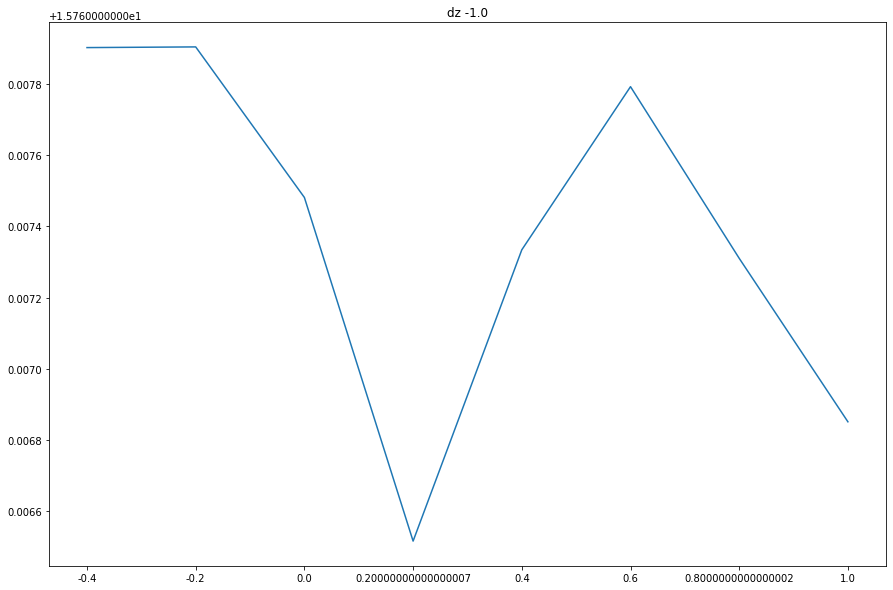

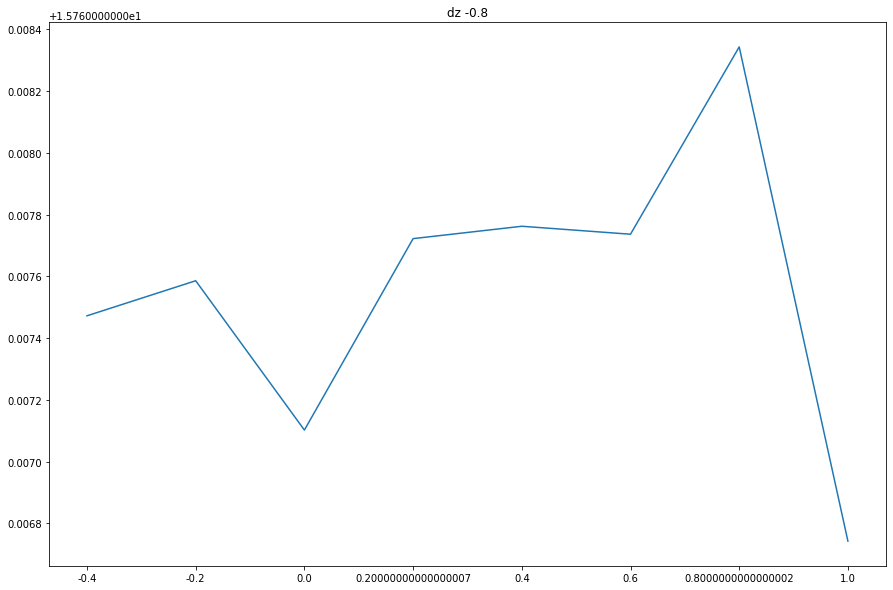

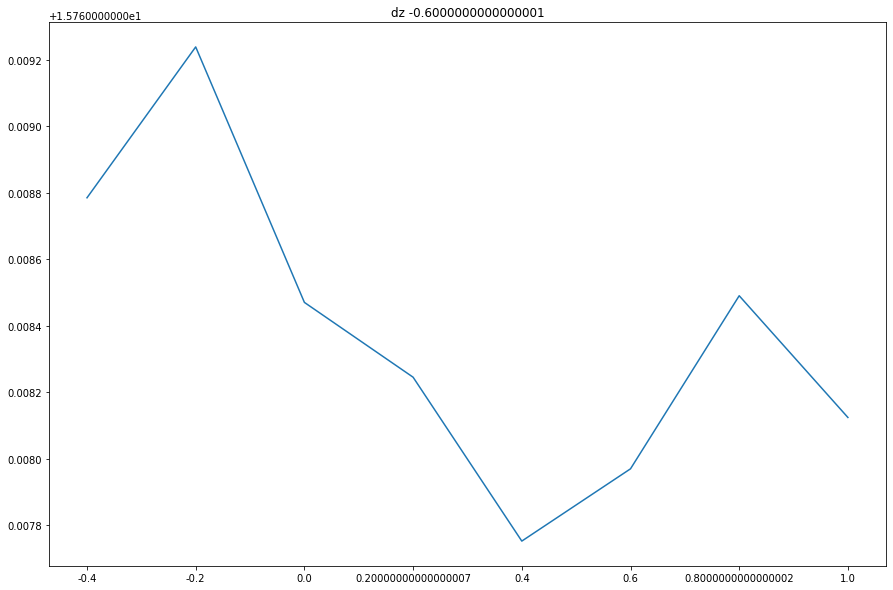

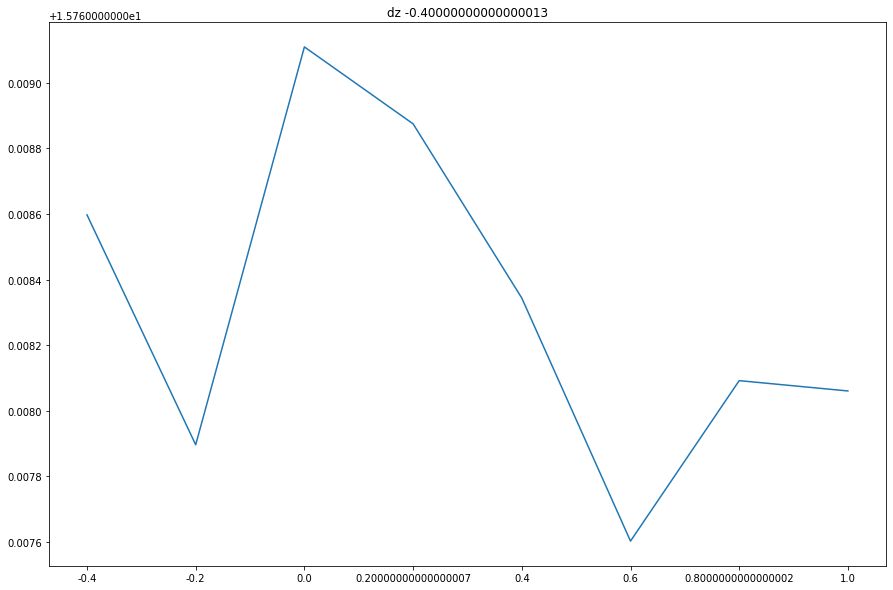

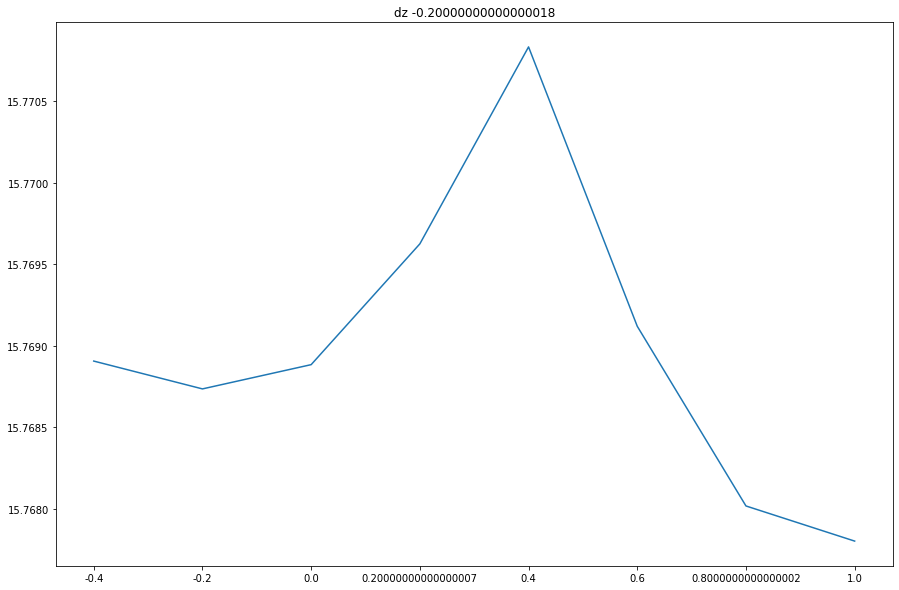

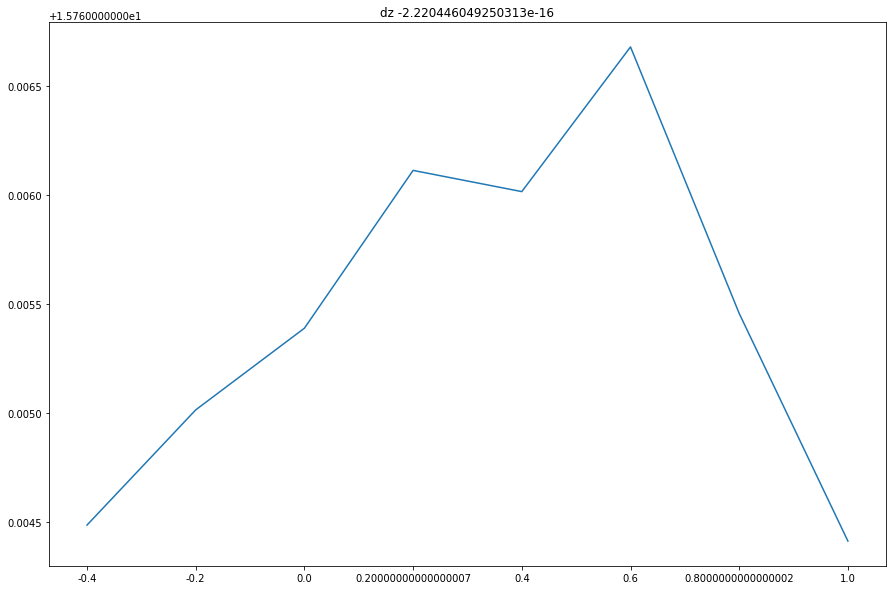

In [460]:
%matplotlib inline
for i,dz in enumerate(z):
    plt.figure(figsize=(15,10))
    plt.plot(entropy_all[:,i,0])
    plt.xticks(range(len(x)),x)
    
    plt.title("dz {}".format(dz))

In [461]:
id_x_min,id_z_min,id_y_min=np.unravel_index(np.argmin(entropy_all),entropy_all.shape)

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [462]:
print("min entropy dx {}".format(x[id_x_min]))
print("min entropy dz {}".format(z[id_z_min]))

min entropy dx 1.0
min entropy dz -2.220446049250313e-16


In [463]:
alpha_min

array([ 1.00000000e+00,  0.00000000e+00, -2.22044605e-16])

In [487]:
modif_final.shape

(1400, 48, 800)

In [490]:
displacements_extrapolated.shape

(67200,)

In [491]:
dx=alpha_min[0]
dz=alpha_min[2]
dy=alpha_min[1]

alpha = np.array([dx, dy, dz])
dr = np.expand_dims(alpha, axis=(0, 1)) * np.expand_dims(
                    displacements_extrapolated.reshape(nb_slices, nb_segments).T, axis=(2))
modif = np.exp(
                    1j * np.sum((traj_all.reshape(nb_segments, -1, npoint, 3) * np.expand_dims(dr, axis=2)),
                                axis=-1))
data_modif = kdata_all_channels_all_slices[ch] * modif
volume_ch_modif = \
                    simulate_radial_undersampled_images_multi(np.expand_dims(data_modif[selected_spokes],axis=0), radial_traj, image_size, b1=b1_full,
                                                              density_adj=dens_adj, ntimesteps=1, useGPU=False,
                                                              normalize_kdata=False, memmap_file=None,
                                                              light_memory_usage=light_memory_usage,
                                                              normalize_volumes=True)[0]


(15360000, 3)


100%|██████████| 1/1 [00:00<00:00, 36.45it/s]


Performing NUFFT


0it [00:00, ?it/s]
  0%|          | 0/1 [00:00<?, ?it/s]

(14822400, 3)
(14822400,)



100%|██████████| 1/1 [00:02<00:00,  2.40s/it]
1it [00:02,  2.40s/it]


Normalizing by Coil Sensi


100%|██████████| 1/1 [00:00<00:00, 25.08it/s]


In [492]:
print("Original entropy : {}".format(calc_grad_entropy(volume_ch[center_pixel[0]-int(window[0]/2):center_pixel[0]+int(window[0]/2),center_pixel[1]-int(window[1]/2):center_pixel[1]+int(window[1]/2),center_pixel[2]-int(window[2]/2):center_pixel[2]+int(window[2]/2)]),w=grad_weights))
print("New entropy : {}".format(calc_grad_entropy(volume_ch_modif[center_pixel[0]-int(window[0]/2):center_pixel[0]+int(window[0]/2),center_pixel[1]-int(window[1]/2):center_pixel[1]+int(window[1]/2),center_pixel[2]-int(window[2]/2):center_pixel[2]+int(window[2]/2)]),w=grad_weights))

Original entropy : 15.76158618927002
New entropy : 15.757765769958496


/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [493]:
print("Original entropy : {}".format(calc_entropy(volume_ch[center_pixel[0]-int(window[0]/2):center_pixel[0]+int(window[0]/2),center_pixel[1]-int(window[1]/2):center_pixel[1]+int(window[1]/2),center_pixel[2]-int(window[2]/2):center_pixel[2]+int(window[2]/2)])))
print("New entropy : {}".format(calc_entropy(volume_ch_modif[center_pixel[0]-int(window[0]/2):center_pixel[0]+int(window[0]/2),center_pixel[1]-int(window[1]/2):center_pixel[1]+int(window[1]/2),center_pixel[2]-int(window[2]/2):center_pixel[2]+int(window[2]/2)])))

Original entropy : 26958.099609375
New entropy : 26904.21875


<IPython.core.display.Javascript object>


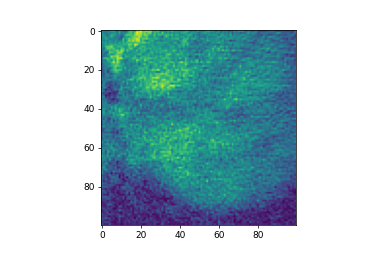

<IPython.core.display.Javascript object>


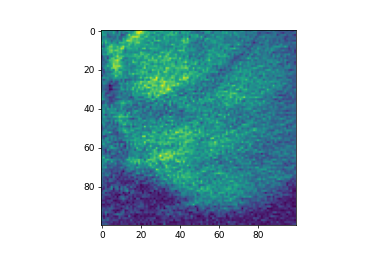

(<matplotlib.animation.ArtistAnimation at 0x7fc8e6e8d910>,
 <matplotlib.animation.ArtistAnimation at 0x7fc8e6e8d6d0>)

In [471]:
%matplotlib notebook
interval=1000
animate_multiple_images(volume_ch[center_pixel[0]-int(window[0]/2):center_pixel[0]+int(window[0]/2),center_pixel[1]-int(window[1]/2):center_pixel[1]+int(window[1]/2),center_pixel[2]-int(window[2]/2):center_pixel[2]+int(window[2]/2)]*hann_3D,volume_ch_modif[center_pixel[0]-int(window[0]/2):center_pixel[0]+int(window[0]/2),center_pixel[1]-int(window[1]/2):center_pixel[1]+int(window[1]/2),center_pixel[2]-int(window[2]/2):center_pixel[2]+int(window[2]/2)]*hann_3D,interval=interval)

In [478]:

def animate_multiple_images(images_series,images_series_rebuilt,interval=200,pause=1000,cmap=None):
    nb_frames=len(images_series)
    fig, ax = plt.subplots()
    fig_rebuilt, ax_rebuilt = plt.subplots()
    # ims is a list of lists, each row is a list of artists to draw in the
    # current frame; here we are just animating one artist, the image, in
    # each frame
    ims = []
    ims_rebuilt = []
    for i in range(nb_frames):
        im = ax.imshow(np.abs(images_series[i]), animated=True,cmap=cmap)
        if i == 0:
            ax.imshow(np.abs(images_series[i]),cmap=cmap)  # show an initial one first
        ims.append([im])

        im_rebuilt = ax_rebuilt.imshow(np.abs(images_series_rebuilt[i]), animated=True,cmap=cmap)
        if i == 0:
            ax_rebuilt.imshow(np.abs(images_series_rebuilt[i]),cmap=cmap)  # show an initial one first
        ims_rebuilt.append([im_rebuilt])

    return animation.ArtistAnimation(fig, ims, interval=interval, blit=True,
                                    repeat_delay=pause),animation.ArtistAnimation(fig_rebuilt, ims_rebuilt, interval=interval, blit=True,
                                    repeat_delay=pause),

<IPython.core.display.Javascript object>


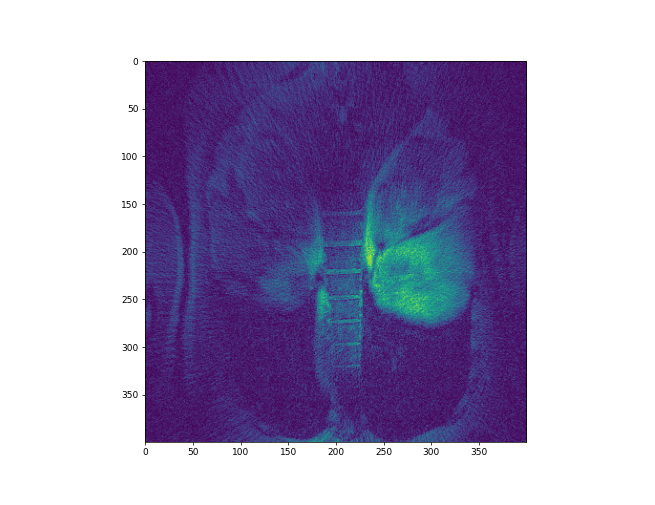

<IPython.core.display.Javascript object>


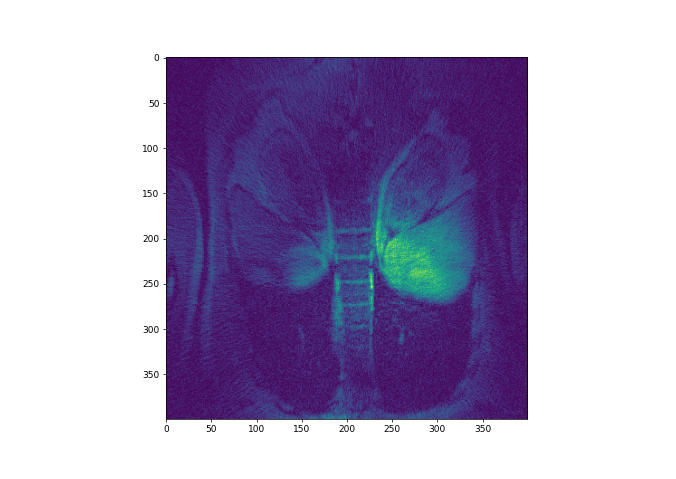

(<matplotlib.animation.ArtistAnimation at 0x7fc8e69dc0a0>,
 <matplotlib.animation.ArtistAnimation at 0x7fc8e6ed37f0>)

In [479]:
%matplotlib notebook
interval=2000
#pause=3000
animate_multiple_images(volume_ch[center_pixel[0]-int(window[0]/2):center_pixel[0]+int(window[0]/2)],volume_ch_modif[center_pixel[0]-int(window[0]/2):center_pixel[0]+int(window[0]/2)],interval=interval)

In [494]:
modif_final.shape

(1400, 48, 800)

In [495]:
data_modif_final = kdata_all_channels_all_slices* modif_final
np.save(filename_kdata_modif,data_modif_final)

In [ ]:
#b1_all_slices=np.load(filename_b1)

%matplotlib inline
sl=int(b1_all_slices.shape[1]/2)
#sl=4
list_images = list(np.abs(b1_all_slices[:,sl,:,:]))
plot_image_grid(list_images,(6,6),title="Sensitivity map for slice {}".format(sl))

In [100]:
dx=1.0
dz=-0.1
dy=0.0

alpha = np.array([dx, dy, dz])
dr = np.expand_dims(alpha, axis=(0, 1)) * np.expand_dims(
                    displacements_extrapolated.reshape(nb_slices, nb_segments).T, axis=(2))
modif = np.exp(
                    1j * np.sum((radial_traj.get_traj().reshape(nb_segments, -1, npoint, 3) * np.expand_dims(dr, axis=2)),
                                axis=-1))
data_modif = kdata_all_channels_all_slices[ch] * modif
volume_ch_modif = \
                    simulate_radial_undersampled_images_multi(np.expand_dims(data_modif,axis=0), radial_traj, image_size, b1=b1_full,
                                                              density_adj=dens_adj, ntimesteps=1, useGPU=False,
                                                              normalize_kdata=False, memmap_file=None,
                                                              light_memory_usage=light_memory_usage,
                                                              normalize_volumes=True)[0]



(53760000, 3)


100%|██████████| 1/1 [00:00<00:00, 10.84it/s]


Performing NUFFT


0it [00:00, ?it/s]
  0%|          | 0/1 [00:00<?, ?it/s]

(51916800, 3)
(51916800,)



100%|██████████| 1/1 [00:06<00:00,  6.32s/it]
1it [00:06,  6.32s/it]


Normalizing by Coil Sensi


100%|██████████| 1/1 [00:00<00:00, 25.35it/s]


In [480]:
data_modif.shape

(400, 48, 800)

In [101]:
dz_ent_l = 5
dz_ent_r = 5
print("Original entropy : {}".format(calc_grad_entropy(volume_ch[int(nb_slices/2)-dz_ent_l:int(nb_slices/2)+dz_ent_r])))
print("New entropy : {}".format(calc_grad_entropy(volume_ch_modif[int(nb_slices/2)-dz_ent_l:int(nb_slices/2)+dz_ent_r])))


Original entropy : 20.461957931518555
New entropy : 20.457780838012695


/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


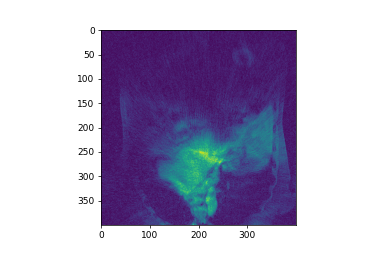

<IPython.core.display.Javascript object>


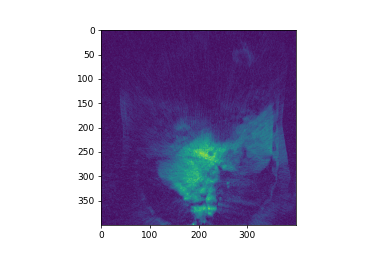

(<matplotlib.animation.ArtistAnimation at 0x7fc8e52804c0>,
 <matplotlib.animation.ArtistAnimation at 0x7fc8e45a2cd0>)

In [217]:
%matplotlib notebook
animate_multiple_images(volume_ch[int(nb_slices/2)-dz_ent_l:int(nb_slices/2)+dz_ent_r],volume_ch_modif[int(nb_slices/2)-dz_ent_l:int(nb_slices/2)+dz_ent_r])

In [ ]:
b1_all_slices=calculate_sensitivity_map_3D(kdata_all_channels_all_slices,radial_traj,res,image_size,useGPU=False,light_memory_usage=light_memory_usage)

In [58]:
volume_full = \
                    simulate_radial_undersampled_images_multi(kdata_all_channels_all_slices, radial_traj, image_size, b1=b1_all_slices,
                                                              density_adj=dens_adj, ntimesteps=1, useGPU=False,
                                                              normalize_kdata=False, memmap_file=None,
                                                              light_memory_usage=light_memory_usage,
                                                              normalize_volumes=True)[0]


(53760000, 3)
float32


100%|██████████| 34/34 [00:03<00:00, 11.10it/s]


Performing NUFFT


0it [00:00, ?it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

(51916800, 3)
(51916800,)



  3%|▎         | 1/34 [00:08<04:42,  8.56s/it]

(51916800, 3)
(51916800,)



  6%|▌         | 2/34 [00:17<04:50,  9.07s/it]

(51916800, 3)
(51916800,)



  9%|▉         | 3/34 [00:25<04:22,  8.48s/it]

(51916800, 3)
(51916800,)



 12%|█▏        | 4/34 [00:31<03:47,  7.59s/it]

(51916800, 3)
(51916800,)



 15%|█▍        | 5/34 [00:37<03:18,  6.85s/it]

(51916800, 3)
(51916800,)



 18%|█▊        | 6/34 [00:42<02:53,  6.20s/it]

(51916800, 3)
(51916800,)



 21%|██        | 7/34 [00:47<02:32,  5.66s/it]

(51916799, 3)
(51916799,)



 24%|██▎       | 8/34 [00:51<02:18,  5.33s/it]

(51916800, 3)
(51916800,)



 26%|██▋       | 9/34 [00:55<02:04,  4.97s/it]

(51916800, 3)
(51916800,)



 29%|██▉       | 10/34 [00:59<01:53,  4.72s/it]

(51916800, 3)
(51916800,)



 32%|███▏      | 11/34 [01:04<01:44,  4.54s/it]

(51916800, 3)
(51916800,)



 35%|███▌      | 12/34 [01:08<01:36,  4.40s/it]

(51916800, 3)
(51916800,)



 38%|███▊      | 13/34 [01:12<01:30,  4.32s/it]

(51916800, 3)
(51916800,)



 41%|████      | 14/34 [01:16<01:25,  4.26s/it]

(51916800, 3)
(51916800,)



 44%|████▍     | 15/34 [01:20<01:20,  4.25s/it]

(51916800, 3)
(51916800,)



 47%|████▋     | 16/34 [01:24<01:15,  4.22s/it]

(51916800, 3)
(51916800,)



 50%|█████     | 17/34 [01:28<01:11,  4.19s/it]

(51916800, 3)
(51916800,)



 53%|█████▎    | 18/34 [01:33<01:06,  4.16s/it]

(51916800, 3)
(51916800,)



 56%|█████▌    | 19/34 [01:37<01:02,  4.14s/it]

(51916800, 3)
(51916800,)



 59%|█████▉    | 20/34 [01:41<00:58,  4.15s/it]

(51916800, 3)
(51916800,)



 62%|██████▏   | 21/34 [01:45<00:53,  4.14s/it]

(51916800, 3)
(51916800,)



 65%|██████▍   | 22/34 [01:49<00:49,  4.14s/it]

(51916800, 3)
(51916800,)



 68%|██████▊   | 23/34 [01:53<00:45,  4.13s/it]

(51916800, 3)
(51916800,)



 71%|███████   | 24/34 [01:57<00:41,  4.13s/it]

(51916800, 3)
(51916800,)



 74%|███████▎  | 25/34 [02:01<00:37,  4.14s/it]

(51916800, 3)
(51916800,)



 76%|███████▋  | 26/34 [02:06<00:33,  4.13s/it]

(51916800, 3)
(51916800,)



 79%|███████▉  | 27/34 [02:10<00:28,  4.12s/it]

(51916800, 3)
(51916800,)



 82%|████████▏ | 28/34 [02:14<00:24,  4.13s/it]

(51916800, 3)
(51916800,)



 85%|████████▌ | 29/34 [02:18<00:20,  4.14s/it]

(51916800, 3)
(51916800,)



 88%|████████▊ | 30/34 [02:22<00:16,  4.13s/it]

(51916800, 3)
(51916800,)



 91%|█████████ | 31/34 [02:26<00:12,  4.13s/it]

(51916800, 3)
(51916800,)



 94%|█████████▍| 32/34 [02:30<00:08,  4.12s/it]

(51916800, 3)
(51916800,)



 97%|█████████▋| 33/34 [02:34<00:04,  4.13s/it]

(51916800, 3)
(51916800,)



100%|██████████| 34/34 [02:39<00:00,  4.68s/it]
1it [02:39, 159.11s/it]


Normalizing by Coil Sensi


100%|██████████| 1/1 [00:00<00:00, 21.96it/s]


/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


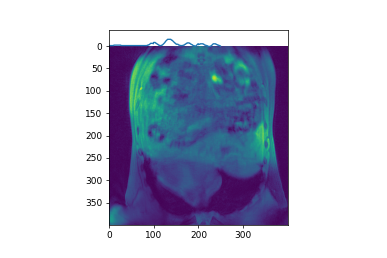

In [59]:
%matplotlib notebook
animate_images(volume_full)